In [1]:
import cv2
import os
import random

from register_dataset import *
from detectron2.engine import DefaultPredictor, default_setup
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo

import matplotlib.pyplot as plt
def cv2_imshow(x, title=None):
    plt.imshow(x[...,::-1])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Registered Dataset
+ cocotrain2014, cocoval2014, 
+ Shiptrainval, Shiptest, 
+ Ship_Part1trainval, Ship_Part1test, 
+ SSDDtrainval, SSDDtest, 
+ VOC2007trainval, VOC2007test, 
+ AIR-SARShip-1.0trainval, AIR-SARShip-1.0test, 
+ AIR-SARShip-2.0trainval, AIR-SARShip-2.0test, 
+ HRSIDtrain2017, HRSIDtest2017, HRSIDtrain_test2017

In [2]:
dataset_name_train = "HRSIDtrain2017"
dataset_name_test = "HRSIDtest2017"
dataset_metadata = MetadataCatalog.get(dataset_name_train)
dataset_dicts = DatasetCatalog.get(dataset_name_train)

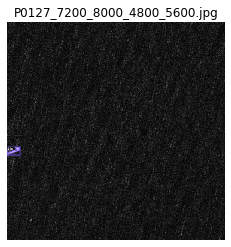

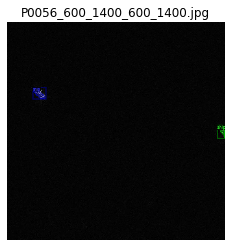

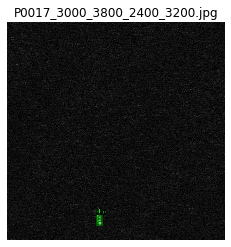

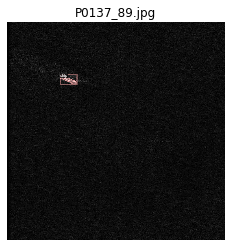

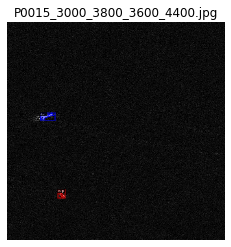

In [3]:
nr_of_samples = 5
scale = 0.5
for d in random.sample(dataset_dicts, nr_of_samples):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[..., ::-1], metadata=dataset_metadata, scale=scale)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image(), title=os.path.split(d["file_name"])[1])

# Load model

In [4]:
def setup(config_file):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml") 
    cfg.merge_from_file(config_file)
    default_setup(cfg, None)
    return cfg

In [5]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg = setup(config_file='yamls/HRSID/Retinanet-R50.yaml' )
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # custom testing threshold for R-CNN
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.1   
predictor = DefaultPredictor(cfg)

Loading config /home/jtli/SAR/detectron2/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[02/05 18:12:23 detectron2]: Rank of current process: 0. World size: 1
[02/05 18:12:24 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0]
numpy                   1.18.5
detectron2              0.3 @/home/jtli/SAR/detectron2/detectron2
Compiler                GCC 8.3
CUDA compiler           CUDA 10.1
detectron2 arch flags   7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.1+cu101 @/home/jtli/anaconda3/lib/python3.7/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0,1                 TITAN RTX (arch=7.5)
CUDA_HOME               /usr/local/cuda
Pillow                  7.2.0
torchvision             0.8.2+cu101 @/home/jtli/anaconda3/lib/python3.7/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5
fvcore                  0.1.2.post20201122

# Visualization

[02/05 18:12:28 d2.data.datasets.coco]: Loaded 1962 images in COCO format from /home/jtli/SAR/dataset/HRSID/annotations/test2017.json


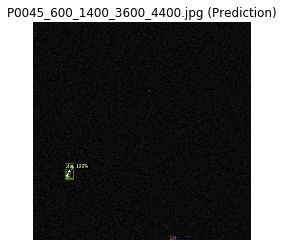

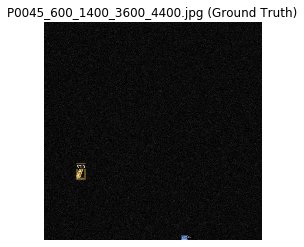

##################################################


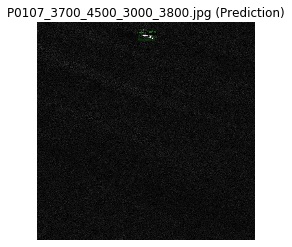

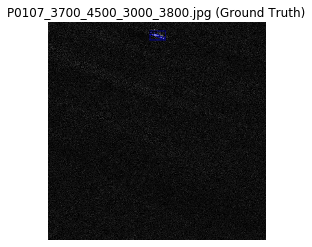

##################################################


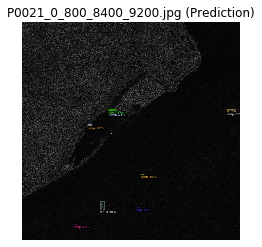

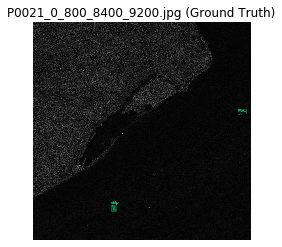

##################################################


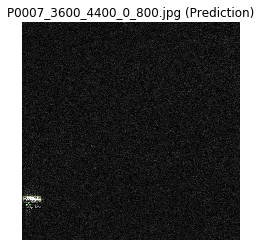

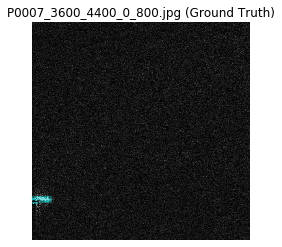

##################################################


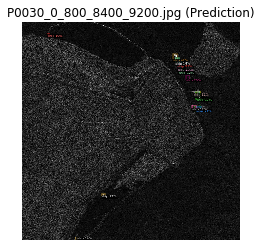

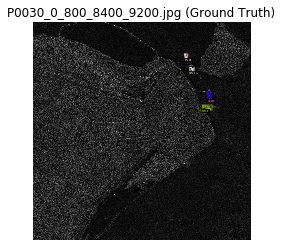

##################################################


In [6]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get(dataset_name_test)
dataset_metadata = MetadataCatalog.get(dataset_name_test)

for d in random.sample(dataset_dicts, nr_of_samples):
    im = cv2.imread(d["file_name"])
    name = os.path.split(d["file_name"])[1]
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v1 = Visualizer(im[..., ::-1],
                   metadata=dataset_metadata,
                   scale=scale, 
    )
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image(), title=f"{name} (Prediction)")
    
    v2 = Visualizer(im[..., ::-1], metadata=dataset_metadata, scale=scale)
    out = v2.draw_dataset_dict(d)
    cv2_imshow(out.get_image(), title=f"{name} (Ground Truth)")
    print("#"*50)

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import COCOEvaluator

class Trainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each builtin dataset.
        For your own dataset, you can simply create an evaluator manually in your
        script and do not have to worry about the hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, f"inference")
        return COCOEvaluator(dataset_name, ["bbox"], True, output_folder)
    
    
model = Trainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(cfg.MODEL.WEIGHTS, resume=True)
Trainer.test(cfg, model)

[02/05 18:12:30 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

OrderedDict([('bbox',
              {'AP': 57.665436037944474,
               'AP50': 84.26868863556429,
               'AP75': 64.30958052660397,
               'APs': 58.23045516612325,
               'APm': 64.77527123062072,
               'APl': 39.86668634452258})])